In [1]:
from amm import amm
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick

#  Pool configuration

In [2]:
''' Initial reserves '''
Rx0   = np.array([100,   100,   100], float)
Ry0   = np.array([1000,  1000,  1000], float)

''' Fee rate '''
phi   = np.array([0.003, 0.003, 0.003], float)

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

In [3]:
print('Available liquidity coins:', np.round(pools.L, 3))

Available liquidity coins: [316.228 316.228 316.228]


In [8]:
amm.swap_and_mint(np.array([10, 0, 0]))

TypeError: swap_and_mint() missing 1 required positional argument: 'x'

# Swapping

In [10]:
''' Swapping 1   coin-X in pool 1, 
             0.5 coin-X in pool 2, 
             0.1 coin-X in pool 3 '''
y = pools.swap_x_to_y([1, 0.5, 0.1], quote=False)

print('Obtained Y coins :', np.round(y, 2))
print('Reserves in X    :', pools.Rx)
print('Reserves in Y    :', np.round(pools.Ry, 2))

Obtained Y coins : [9.87 4.96 1.  ]
Reserves in X    : [101.  100.5 100.1]
Reserves in Y    : [990.13 995.04 999.  ]


# Minting and burning

In [11]:
''' Minting with incorrect amount '''

x = [1, 1, 1]

l = pools.mint(x = x, y = np.random.rand(3))

AssertionError: pool 0 has incorrect submission of tokens

In [ ]:
''' Minting with correct amount '''

y = x * pools.Ry / pools.Rx

l = pools.mint(x = x, y = y)

print('Trader liquidity coins :', np.round(pools.l, 2))
print('Pool liquidity coins   :', np.round(pools.L, 2))

In [12]:
''' Burning incorrect amount of LP coins '''

x, y = pools.burn(l+1)

NameError: name 'l' is not defined

In [13]:
''' Burning correct amount of LP coints '''
x, y = pools.burn(l)

NameError: name 'l' is not defined

In [14]:
print('Trader LP coins        :', np.round(pools.l, 2))
print('Trader X coins         :', np.round(x, 2))
print('Trader Y coins         :', np.round(y, 2))
print('Pool LP coins          :', np.round(pools.L, 2))

Trader LP coins        : [0. 0. 0.]
Trader X coins         : [1 1 1]
Trader Y coins         : [9.87 4.96 1.  ]
Pool LP coins          : [316.23 316.23 316.23]


# Swapping then minting/burning

In [15]:
''' Swapping 10 coin-X in each pool and minting '''
l = pools.swap_and_mint([10, 10, 10])

print('Minted LP coins       :', np.round(l, 2))
print('Total trader LP coins :', np.round(pools.l, 2))
print('Available LP coins    :', np.round(pools.L, 2))


Minted LP coins       : [15.26 15.34 15.4 ]
Total trader LP coins : [15.26 15.34 15.4 ]
Available LP coins    : [331.49 331.56 331.62]


# Burning then swapping

In [16]:
''' Burning and swapping the l LP coins '''

total_x = pools.burn_and_swap(l)

print('Number of X coins received   :', np.round(total_x, 2))
print('Total trader LP coins        :', np.round(pools.l, 2))
print('Available LP coins           :', np.round(pools.L, 2))


Number of X coins received   : [9.97 9.97 9.97]
Total trader LP coins        : [0. 0. 0.]
Available LP coins           : [316.23 316.23 316.23]


# Simulation example

In [17]:
""" Fix the seed """
np.random.seed(999983)

""" Initialise the pools """
Rx0   = np.array([100,   100,   100], float)
Ry0   = np.array([1000,  1000,  1000], float)
phi   = np.array([0.003, 0.003, 0.003], float)

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

""" Swap and mint """
xs_0 = [10, 10, 10]
l    = pools.swap_and_mint(xs_0)

""" Simulate 1000 paths of trading in the pools """
batch_size = 1_000
T          = 60
kappa      = np.array([0.6,  0.5,  1,     2])
p          = np.array([0.85, 0.3,  0.2,   0.3])
sigma      = np.array([0.05, 0.01, 0.025, 0.05])

end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t =\
        pools.simulate( kappa = kappa, p = p, sigma = sigma, T = T, batch_size = batch_size)

print('Reserves in asset X for scenario 0:', end_pools[0].Rx)
print('Reserves in asset Y for scenario 0:', end_pools[0].Ry)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.25it/s]

Reserves in asset X for scenario 0: [ 96.49101693 118.36668868 121.08317029]
Reserves in asset Y for scenario 0: [1142.26798192  931.52147691  912.31146597]


In [18]:
N = 1
end_pools[N].Rx, end_pools[N].Ry, end_pools[N].l, end_pools[N].L

(array([101.9382401 , 122.61919258, 166.25413695]),
 array([1080.6286639 ,  898.96488084,  663.80857799]),
 array([15.41152698, 15.41152698, 15.41152698]),
 array([331.639293, 331.639293, 331.639293]))

In [19]:
""" Burn and swap all coins into x """
x_T = np.zeros(batch_size)
for k in range(batch_size):
    x_T[k] = np.sum(end_pools[k].burn_and_swap(l))

x_0      = np.sum(xs_0)
log_ret  = np.log(x_T) - np.log(x_0) # performance / log return

print('Average performance     :', np.mean(log_ret)/T*100)
print('Std. Dev. of performance:', np.std(log_ret)/np.sqrt(T)*100)

Average performance     : 0.1021503496734054
Std. Dev. of performance: 0.8841039062999252


# Plot the performance distribution

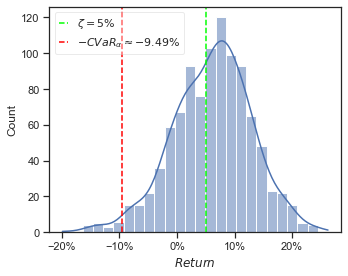

In [20]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,4), sharey=True)

x_0      = np.sum(xs_0)
log_ret  = np.log(x_T) - np.log(x_0)

# histogram plot
sns.histplot(ax=ax, x=100*log_ret, kde=True)
ax.set_xlabel(r'$Return$')

# compute cvar
alpha = 0.95 # 95% 
qtl   = np.quantile(-log_ret, alpha)
cvar  = np.mean(-log_ret[-log_ret>=qtl])

zeta  = 0.05 # 5% 
ax.axvline(zeta*100, linestyle='--', color='lime', label=r"$\zeta = 5\%$")
ax.axvline(-cvar*100, linestyle='--', color='red', label=r'$- CVaR_\alpha\approx$'+f'$-{round(100*cvar, 2)}\%$')

ax.xaxis.set_major_formatter(mtick.PercentFormatter())

plt.legend(handlelength=0.8, framealpha=0.4, loc='upper left')
plt.tight_layout()
plt.savefig('cvar.pdf')
plt.show()

# Other plots

#### Visualize price reserve simulation paths

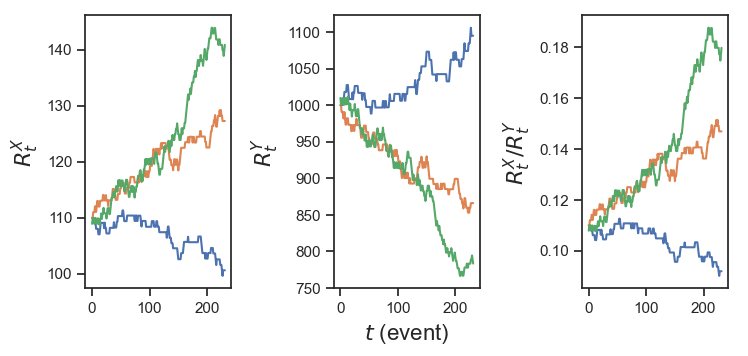

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(8,4))

j = 4

# reserves of coin-X
ax[0].plot(np.array(Rx_t[j]))
ax[0].set_ylabel(r'$R^X_t$', fontsize=16)

# reserves of coin-Y
ax[1].plot(np.array(Ry_t[j]))
ax[1].set_ylabel(r'$R^Y_t$', fontsize=16)

# marginal price
ax[2].plot(np.array(Rx_t[j])/np.array(Ry_t[j]))
ax[2].set_ylabel(r'$R^X_t/R^Y_t$', fontsize=16)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'$t$ (event)', fontsize=16)

plt.tight_layout(pad=1.1)
plt.show()

#### Histogram of terminal marginal prices

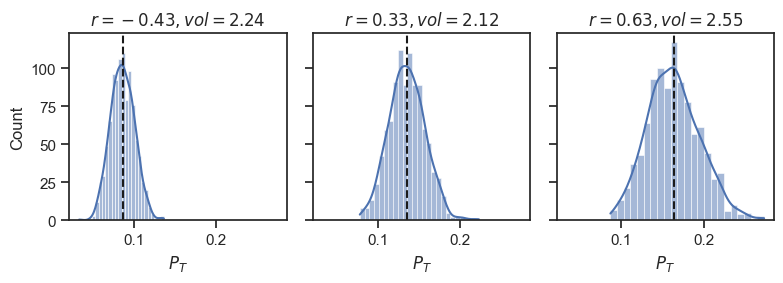

In [16]:
#%% plot histogram of terminal marginal price
Rx_T = np.zeros((batch_size,len(pools.Rx)))
Ry_T = np.zeros((batch_size,len(pools.Rx)))

for k in range(batch_size):
    Rx_T[k,:] = Rx_t[k][-1]
    Ry_T[k,:] = Ry_t[k][-1]

# initial marginal price
P_0 = pools.Rx / pools.Ry

# terminal marginal price
P_T = Rx_T / Ry_T

fig, ax = plt.subplots(nrows=1, ncols=len(Rx0), sharex=True, figsize=(8,3), sharey=True)

for k in range(len(Rx0)):
    log_ret  = np.log(P_T[:,k]/P_0[k]) # log return of the marginal price
    mean_ret = np.mean(log_ret)/T*100
    std_ret  = np.std(log_ret)/np.sqrt(T)*100
    
    # histogram plot
    sns.histplot(ax=ax[k], x=P_T[:,k], kde=True)
    ax[k].axvline(np.mean(P_T[:,k]), linestyle='--', color='k')
    ax[k].set_title('$r={:.2f}'.format(mean_ret) +', vol={:.2f}'.format(std_ret) + '$', fontsize=12)
    ax[k].set_xlabel(r'$P_T$')
    
plt.tight_layout()
plt.show()